170498071/170498071 [==============================] - 13s 0us/step
Epoch 1/10
1563/1563 [==============================] - 21s 7ms/step - loss: 1.5748 - accuracy: 0.4234 - val_loss: 1.3890 - val_accuracy: 0.5066
Epoch 2/10
1563/1563 [==============================] - 10s 7ms/step - loss: 1.0635 - accuracy: 0.6136 - val_loss: 1.2147 - val_accuracy: 0.5784
Epoch 3/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.8438 - accuracy: 0.6968 - val_loss: 1.1809 - val_accuracy: 0.5931
Epoch 4/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.7019 - accuracy: 0.7477 - val_loss: 1.0493 - val_accuracy: 0.6485
Epoch 5/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.5759 - accuracy: 0.7950 - val_loss: 0.9787 - val_accuracy: 0.6929
Epoch 6/10
1563/1563 [==============================] - 10s 7ms/step - loss: 0.4772 - accuracy: 0.8291 - val_loss: 0.9302 - val_accuracy: 0.7036
Epoch 7/10
1563/1563 [==============================] - 10s 7m

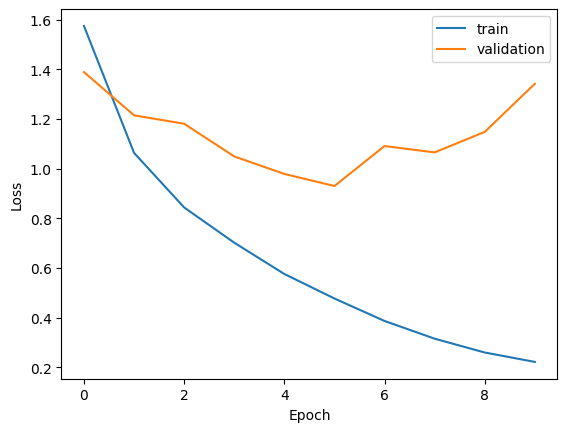

313/313 [==============================] - 1s 3ms/step - loss: 1.3419 - accuracy: 0.6986
Test accuracy: 0.6985999941825867
313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.73      0.69      0.71      1000
           1       0.90      0.82      0.85      1000
           2       0.57      0.62      0.60      1000
           3       0.47      0.63      0.54      1000
           4       0.54      0.79      0.64      1000
           5       0.78      0.36      0.50      1000
           6       0.76      0.78      0.77      1000
           7       0.82      0.69      0.75      1000
           8       0.80      0.85      0.82      1000
           9       0.85      0.76      0.80      1000

    accuracy                           0.70     10000
   macro avg       0.72      0.70      0.70     10000
weighted avg       0.72      0.70      0.70     10000



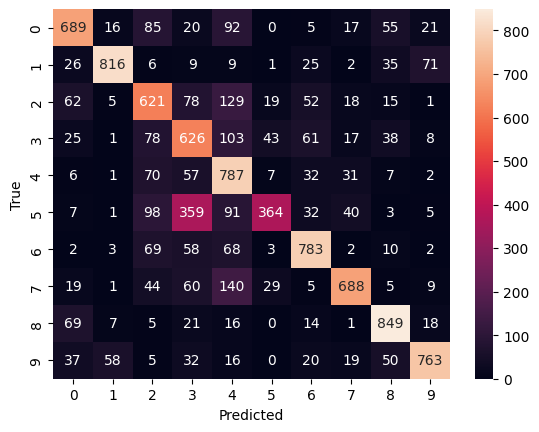

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Define the encoder
class ConvBlock(Model):
    def __init__(self, num_filters, kernel_size, stride_length, pooling_size, pooling_stride, padding_type='same'):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv2D(filters=num_filters, kernel_size=kernel_size, strides=stride_length, padding=padding_type, activation='relu')
        self.bn = BatchNormalization()
        self.pool = MaxPooling2D(pool_size=pooling_size, strides=pooling_stride)

    def call(self, x):
        x = self.conv1(x)
        x = self.bn(x)
        x = self.pool(x)
        return x

class Conv6_Encoder(Model):
    def __init__(self, latent_dim=10):
        super(Conv6_Encoder, self).__init__()
        self.conv_block1 = ConvBlock(64, 3, 1, 2, 2, padding_type='valid')
        self.conv_block2 = ConvBlock(128, 3, 1, 2, 2, padding_type='valid')
        self.conv_block3 = ConvBlock(256, 3, 1, 2, 2, padding_type='same')
        self.flatten = Flatten()
        self.output_layer = Dense(units=latent_dim, activation='relu')

    def call(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.flatten(x)
        x = self.output_layer(x)
        return x

# Define the encoder and classifier
latent_dim = 10
encoder = Conv6_Encoder(latent_dim=latent_dim)

class EncoderClassifier(Model):
    def __init__(self, encoder, num_classes):
        super(EncoderClassifier, self).__init__()
        self.encoder = encoder
        self.classifier = Dense(num_classes, activation='softmax')

    def call(self, x):
        x = self.encoder(x)
        return self.classifier(x)

# Initialize the classifier
num_classes = 10
classifier = EncoderClassifier(encoder, num_classes)

# Compile the model
classifier.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# Train the model
history = classifier.fit(x_train, y_train,
                         epochs=10,
                         validation_data=(x_test, y_test))

# Plot loss for each epoch
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
loss, accuracy = classifier.evaluate(x_test, y_test)
print(f'Test accuracy: {accuracy}')

# Get predictions
y_pred = classifier.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate precision, recall, f1-score
report = classification_report(y_test, y_pred_classes)
print(report)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
